In [33]:
import sys
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [34]:
"""
Dimensions need to be checked between n_users. n_items and X before calling this
"""

class Bias_Model(nn.Module):
  
    def __init__(self, n_users, n_items, nan_map, rand_init=True, max_bias=3, min_bias=0):
        super().__init__()
        torch.manual_seed(0)
        self.user_bias = nn.Parameter(torch.zeros(n_users))
        self.item_bias = nn.Parameter(torch.zeros(n_items))
        self.nan_map = nan_map
        if rand_init:
            nn.init.uniform_(self.user_bias, min_bias, max_bias)
            nn.init.uniform_(self.item_bias, min_bias, max_bias)
    
    def forward(self, X):
        y_pred = torch.cartesian_prod(self.user_bias, self.item_bias).sum(-1).view(len(self.user_bias), len(self.item_bias))
        y_pred = torch.where(self.nan_map, torch.zeros_like(y_pred), y_pred)
        return y_pred
        

In [35]:
def fit_v1(interaction_matrix, model, nan_map, epochs=50, learning_rate=0.6, wt_decay=1e-10):
    loss_arr = []
    opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wt_decay)
    
    X_train = torch.where(nan_map, torch.zeros_like(interaction_matrix), interaction_matrix)
    
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = F.mse_loss(y_hat, X_train)
        print("Epoch # {} --> mse_loss: {}".format(epoch, loss.item()))
        loss_arr.append(loss.item())

        loss.backward()
        opt.step()
        opt.zero_grad()


    plt.plot(loss_arr, 'r-')
    plt.show()      
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

## Training on Magazine data

#### Load the train and test files

In [36]:
torch.set_default_tensor_type(torch.DoubleTensor)

import dill

load_path = "file_server/processed_data/iteration1/magazine_subscription_subset_115X18241/"

# train_matrix
train_matrix = dill.load(open(load_path+"train_matrix.pkl", "rb"))

# train_users
train_users = dill.load(open(load_path+"train_users.pkl", "rb"))

# items (common for train and test)
items = dill.load(open(load_path+"items.pkl", "rb"))

# test_matrix
test_matrix = dill.load(open(load_path+"test_matrix.pkl", "rb"))

# test_users
test_users = dill.load(open(load_path+"test_users.pkl", "rb"))

In [37]:
# Convert train_matrix to torch tensor and calc n_users and n_items
train_matrix = torch.from_numpy(train_matrix)

# Create nan_map, get n_users and n_items
nan_mp = torch.isnan(train_matrix)
n_users, n_items = len(train_users), len(items)

In [38]:
train_matrix.shape, nan_mp.shape

(torch.Size([115, 18241]), torch.Size([115, 18241]))

Epoch # 0 --> mse_loss: 0.03044120304740535
Epoch # 1 --> mse_loss: 0.014593096862616175
Epoch # 2 --> mse_loss: 0.007663911355309036
Epoch # 3 --> mse_loss: 0.005315587948900306
Epoch # 4 --> mse_loss: 0.004442919329301933
Epoch # 5 --> mse_loss: 0.004075705765367349
Epoch # 6 --> mse_loss: 0.004082896259363736
Epoch # 7 --> mse_loss: 0.004220149688528311
Epoch # 8 --> mse_loss: 0.004218099084371345
Epoch # 9 --> mse_loss: 0.004044472853133716
Epoch # 10 --> mse_loss: 0.003807217285036366
Epoch # 11 --> mse_loss: 0.003549923576316235
Epoch # 12 --> mse_loss: 0.003229764862433004
Epoch # 13 --> mse_loss: 0.0028240715453218893
Epoch # 14 --> mse_loss: 0.0023794942545085056
Epoch # 15 --> mse_loss: 0.0019727802805645945
Epoch # 16 --> mse_loss: 0.001661379004753514
Epoch # 17 --> mse_loss: 0.0014627778215432242
Epoch # 18 --> mse_loss: 0.0013618831514889621
Epoch # 19 --> mse_loss: 0.0013244333047541725
Epoch # 20 --> mse_loss: 0.0013093668462225276
Epoch # 21 --> mse_loss: 0.00128121676

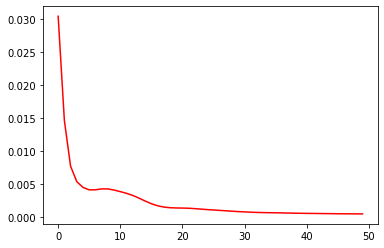

Loss before training 0.03044120304740535
Loss after training 0.0004204620824790337
CPU times: user 13.6 s, sys: 18.2 s, total: 31.8 s
Wall time: 2.05 s


In [39]:
%%time
# create and fit the model
model_v3 = Bias_Model(n_users=n_users, n_items=n_items, nan_map=nan_mp)
fit_v1(interaction_matrix=train_matrix, nan_map=nan_mp, model=model_v3)

## Testing of test dataset

In [40]:
# create completed matrix
completed_matrix = torch.cartesian_prod(model_v3.user_bias, model_v3.item_bias).sum(-1).view(len(model_v3.user_bias), len(model_v3.item_bias))

# replace original training values using nan_mp
completed_matrix = torch.where(nan_mp, completed_matrix, train_matrix).detach().numpy()

In [41]:
# get index of users in train set who are present in test set
common_user_indices = np.argwhere(np.in1d(train_users, test_users))

In [49]:
def pointwise_mad_between_1darrays(arr1, arr2):
    """
    This function returns a np.array of (index, mad_value) tuple, 
    index signifying which index at both arrays were used to compute the value.
    If either of the arrays have NaN value at any given index, then its ignored for computation
    """
    try:
        if len(arr1) != len(arr2):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(arr1)):
            if ~np.isnan(arr1[i]) and ~np.isnan(arr2[i]):
                result.append((i, abs(float(arr1[i]) - float(arr2[i]))))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(arr1, arr2)
        print(error_type, error_instance, traceback)
        

def pointwise_accuracy_ceil_or_floor(true_arr, pred_arr):
    """
    Returns a np.array of (index, accuracy_value) tuple.
    accuracy_val = 1, when true_arr E {ceil(pred_arr), floor(pred_arr)}, 0 otherwise. 
    Missing values in either arrays are discarded for computation
    """
    try:
        if len(true_arr) != len(pred_arr):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(true_arr)):
            if ~np.isnan(true_arr[i]) and ~np.isnan(pred_arr[i]):
                if int(true_arr[i]) in [math.floor(float(pred_arr[i])), math.ceil(float(pred_arr[i]))]:
                    result.append((i, 1))
                else:
                    result.append((i, 0))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(true_arr, pred_arr)
        print(error_type, error_instance, traceback)
    
    
def pointwise_accuracy_ceil_or_floor_add1(true_arr, pred_arr):
    """
    Returns a np.array of (index, accuracy_value) tuple.
    accuracy_val = 1, when true_arr E {ceil(pred_arr) + 1, floor(pred_arr) - 1}, 0 otherwise. 
    Missing values in either arrays are discarded for computation
    """
    try:
        if len(true_arr) != len(pred_arr):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(true_arr)):
            if ~np.isnan(true_arr[i]) and ~np.isnan(pred_arr[i]):
                if int(true_arr[i]) in [
                    math.floor(float(pred_arr[i])) - 1 ,
                    math.ceil(float(pred_arr[i])) + 1,
                    math.floor(float(pred_arr[i])),
                    math.ceil(float(pred_arr[i]))
                ]:
                    result.append((i, 1))
                else:
                    result.append((i, 0))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(true_arr, pred_arr)
        print(error_type, error_instance, traceback)

        
def metrics_collector(test_matrix, pred_matrix, common_indices, metrics='all'):
    metrics_map = {
        'accuracy_ceil_floor_add1': pointwise_accuracy_ceil_or_floor_add1,
        'accuracy_ceil_floor': pointwise_accuracy_ceil_or_floor,
        'mad': pointwise_mad_between_1darrays
    }
    try:
        if metrics!="all":
            raise ValueError("something something meri jaan")
        metrics_vals = {key:np.ones([1,3]) for key in metrics_map.keys()}
        for i in range(len(test_matrix)):
            for metric, func in metrics_map.items():
                _val = func(test_matrix[i], pred_matrix[common_indices[i][0]])
                _val = np.insert(_val, 0, i, axis=1)
                metrics_vals[metric] = np.append(metrics_vals[metric], _val, axis=0)
        return metrics_vals
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(error_type, error_instance, traceback)

In [50]:
metrics = metrics_collector(test_matrix=test_matrix, pred_matrix=completed_matrix, common_indices=common_user_indices)

In [51]:
metrics

{'accuracy_ceil_floor_add1': array([[1.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 6.6000e+01, 0.0000e+00],
        [0.0000e+00, 3.8100e+02, 1.0000e+00],
        ...,
        [1.0600e+02, 1.3168e+04, 1.0000e+00],
        [1.0600e+02, 1.6530e+04, 1.0000e+00],
        [1.0600e+02, 1.6873e+04, 1.0000e+00]]),
 'accuracy_ceil_floor': array([[1.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 6.6000e+01, 0.0000e+00],
        [0.0000e+00, 3.8100e+02, 0.0000e+00],
        ...,
        [1.0600e+02, 1.3168e+04, 1.0000e+00],
        [1.0600e+02, 1.6530e+04, 0.0000e+00],
        [1.0600e+02, 1.6873e+04, 1.0000e+00]]),
 'mad': array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 6.60000000e+01, 3.00293639e+00],
        [0.00000000e+00, 3.81000000e+02, 1.91807604e+00],
        ...,
        [1.06000000e+02, 1.31680000e+04, 8.19661064e-01],
        [1.06000000e+02, 1.65300000e+04, 1.22751987e+00],
        [1.06000000e+02, 1.68730000e+04, 8.72146027e-01]]

In [52]:
accuracy_ceil_floor = np.delete(metrics['accuracy_ceil_floor'], 0, 0)[:,2]
np.mean(accuracy_ceil_floor)

0.35011157946937765

In [53]:
accuracy_ceil_floor_add1 = np.delete(metrics['accuracy_ceil_floor_add1'], 0, 0)[:,2]
np.mean(accuracy_ceil_floor_add1)

0.7126208777584925

In [54]:
mad = np.delete(metrics['mad'], 0, 0)[:,2]
np.mean(mad)

1.4510915656361518

In [55]:
m2 = np.array(list(map(lambda x: x<2.5, mad)))
np.sum(m2)/len(m2)

0.8611455492189437

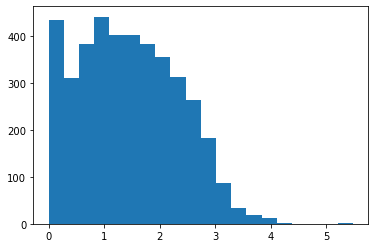

In [56]:
import matplotlib.pyplot as plt

plt.hist(mad, bins=20)
plt.show()

In [57]:
np.std(mad)

0.8866639373270518

## Plotting weights

In [31]:
import seaborn as sns

item_biases = list(model_v3.parameters())[1].data.numpy()
user_biases = list(model_v3.parameters())[0].data.numpy()

[]

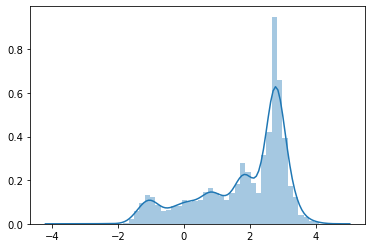

In [32]:
sns.distplot(item_biases.ravel())
plt.plot()

In [ ]:
sns.distplot(item_biases.ravel())
plt.plot()

## Testing with small handcrafted input

In [ ]:
# testing with dummy matrix
train = torch.tensor([
    [4, np.nan, np.nan, 3, 5, 3],
    [np.nan, 1, 2, np.nan, 3, np.nan],
    [4, np.nan, np.nan, 3, 4, 2],
    [5, 1, 2, np.nan, 3, np.nan],
    [4, np.nan, 3, 3, 5, 1]
])

nan_map = torch.isnan(train)
n_users, n_items = train.shape


In [ ]:
model = Bias_Model(n_users=n_users, n_items=n_items, nan_map=nan_map)
fit_v1(interaction_matrix=train, nan_map=nan_map, model=model)

In [ ]:
model_v2 = Bias_Model(n_users=n_users, n_items=n_items, nan_map=nan_map, rand_init=False)
fit_v1(interaction_matrix=train, nan_map=nan_map, model=model_v2)

In [ ]:
model_v2.user_bias, model_v2.item_bias

In [ ]:
model.user_bias, model.item_bias

In [ ]:
final = torch.cartesian_prod(model.user_bias, model.item_bias).sum(-1).view(len(model.user_bias), len(model.item_bias))
final

In [ ]:
final_v2 = torch.cartesian_prod(model_v2.user_bias, model_v2.item_bias).sum(-1).view(len(model_v2.user_bias), len(model_v2.item_bias))
final_v2

In [ ]:
train

In [ ]:
torch.where(nan_map, final, train)

In [ ]:
torch.where(nan_map, final_v2, train)

In [ ]:
import math
def pointwise_mad_and_accuracy_for_non_na(train_row, test_row):
    errors = np.empty(0)
    accuracy = np.empty(0)
    for i in range(len(train_row)):
        if ~np.isnan(train_row[i]) and ~np.isnan(test_row[i]):
            errors = np.append(errors, abs(float(train_row[i]) - float(test_row[i])))
            if int(test_row[i]) in [math.floor(float(train_row[i])), math.ceil(float(train_row[i]))]:
                accuracy = np.append(accuracy, 1)
            else:
                accuracy = np.append(accuracy, 0)
    return errors.mean(), np.mean(accuracy)


In [ ]:
# error_arr, accuracy_arr = np.empty(0), np.empty(0)

# for i in range(len(test_users)):
#     err, acc = pointwise_mad_and_accuracy_for_non_na(test_row=test_matrix[i], train_row=completed_matrix[common_user_indices[i][0]])
#     error_arr = np.append(error_arr, err)
#     accuracy_arr = np.append(accuracy_arr, acc)

# np.median(error_arr), np.median(accuracy_arr)

In [ ]:
# np.count_nonzero(~np.isnan(test_matrix))

### Scribble pad

In [48]:
len(common_user_indices), len(train_matrix), len(test_matrix), common_user_indices[106][0]

(107, 115, 107, 114)

In [ ]:
def some_f(a,b):
    try:
        if len(a) != len(b):
            raise ValueError("Array lengths should be equal")
        print("does this")
    except Exception as e:
        return e

a = [2,4,5]
b = [3,4,1]
X = pointwise_mad_between_1darrays(a,b)
X = np.insert(X, 0, 6., axis=1)
X

In [ ]:
x = np.array([1,2,3,4])
# x = np.insert(x, 0, 1, axis=1)
np.insert(x.reshape(-1, 1), 0, 4, axis=1)

In [ ]:
a = np.ones([1,3])
b = np.array([[1,3,3]])
# print(a, b)
a_del = np.append(a, b, axis=0)
# a_del = np.delete(a_del, 0, 0)
a_del

In [ ]:
np.median(a_del[:,2])

In [14]:
a = torch.tensor([[1,2], [3,4], [4,5]])
b = torch.tensor([[11,21], [31,41], [41,51]])

from torch.utils.data import TensorDataset
tds = TensorDataset(a,b)
tds[1]

(tensor([3, 4]), tensor([31, 41]))

In [16]:
from torch.utils.data import DataLoader
batch = DataLoader(tds, batch_size=2, shuffle=True)

for x,y in batch:
    print(x)
    print(y)
    print("----")

tensor([[3, 4],
        [4, 5]])
tensor([[31, 41],
        [41, 51]])
----
tensor([[1, 2]])
tensor([[11, 21]])
----


In [74]:
s = np.array([[1,np.nan,np.nan], [np.nan,np.nan,np.nan], [np.nan,np.nan,np.nan], [2,np.nan,np.nan]])
u = np.array(['u1', 'u2', 'u3', 'u4'])
i = np.array(['i1', 'i2', 'i3'])

print(s,u,i)

def get_products_with_no_ratings(s):
    col_indices = list()
    for i in range(s.shape[1]):
        if np.count_nonzero(~np.isnan(s[:,i]))==0:
            col_indices.append(i)
    print(col_indices)
    return col_indices

col_to_remove = get_products_with_no_ratings(s)

s = np.delete(s, col_to_remove, axis=1)
# u = np.delete(u, get_products_with_no_ratings(s), axis=0)
i = np.delete(i, col_to_remove, axis=0)

print(s,u,i)

[[ 1. nan nan]
 [nan nan nan]
 [nan nan nan]
 [ 2. nan nan]] ['u1' 'u2' 'u3' 'u4'] ['i1' 'i2' 'i3']
[1, 2]


AxisError: axis 1 is out of bounds for array of dimension 1

In [67]:
items


array(['A0333047WGK24IZKLDP2', 'A0534350D18UHJKPKZ1W',
       'A095896256EBDK3E42GW', ..., 'AZZM0EGX7OIJH', 'AZZP6XXCKUBK1',
       'AZZVFTH1QONVD'], dtype=object)